**************************************
Exp05: Distillation Column
Roll No: 120CH0057, Name: Siddharth Gautam
Running On: Python  3.11.1  on:  2023-04-25 15:32:36.455000
**************************************



,Parameter,Value
0,Minimum Reflux Ratio,1.026007
1,Reflux Ratio,1.539010
2,Number of Ideal Stages,7.000000
3,Feed Tray Location,4.000000
4,Slope of SSOL,2.291353
5,Top Temperature,69.748700
6,Bottom Temperature,119.707500


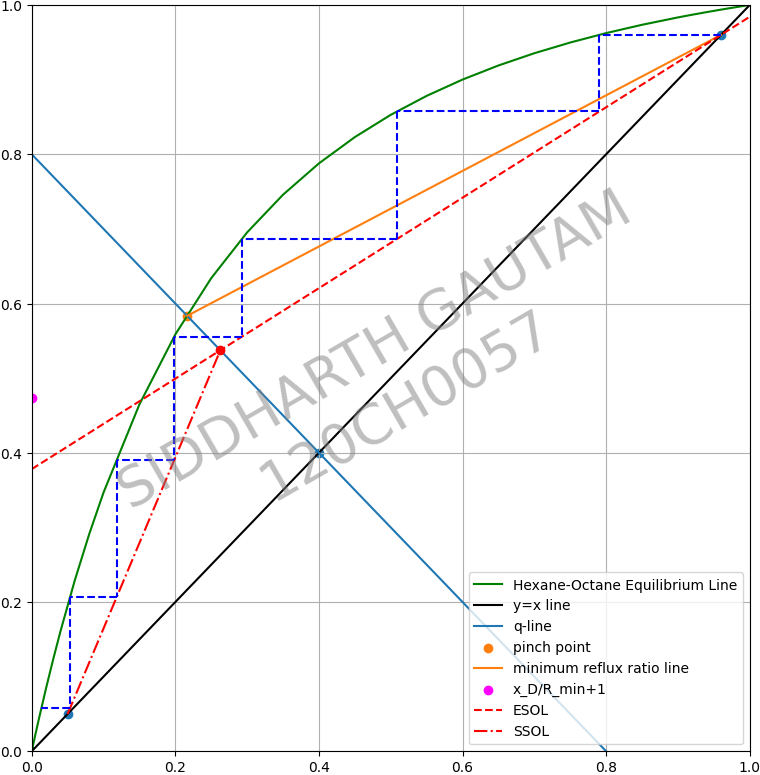

In [2]:
EXPT_NAME="Exp05: Distillation Column"
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import LineString
import warnings

import platform
from datetime import datetime
print("**************************************")
print(EXPT_NAME)
print("Roll No: 120CH0057, Name: Siddharth Gautam")
print("Running On: Python ", platform.python_version(), " on: ", str(datetime.now()))
print("**************************************")
print("")

def prepare_matplotlib(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    plt.autoscale(tight=True)
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.tight_layout()
    warnings.filterwarnings('ignore')

def draw_line(slope, intercept, col='red', lbl=''):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=col, label=lbl)

prepare_matplotlib()
# SECTION 0 : System parameters
x_F = 0.4
x_D = 0.96
x_W = 0.05
q = 0.5
L = 10000
RR_min_to_actual = 1.5
# This data was taken from http://vle-calc.com/
mycsv = pd.read_csv('hexane-octane.csv')
x1 = np.array(mycsv["x1"])
y1 = np.array(mycsv["y1"])
T = np.array(mycsv["Temperature"])

# SECTION 1 : EQUILIBRIUM LINE
plt.plot(x1, y1, color="green", label="Hexane-Octane Equilibrium Line")

# SECTION 2 : plot y=x line
plt.plot([0,1], [0,1], color="black", label="y=x line")

# SECTION 3 : Q-LINE
# plot q-line, calculated for q = 0.5 and x_F = 0.4
# y = (q)/(q-1)*x - x_F/q-1
q_x1 = 0
q_y1 = -x_F/(q-1)
q_y2 = 0
q_x2 = x_F/q
plt.plot([q_x1, q_x2], [q_y1, q_y2], label='q-line')

# SECTION 4 : X_F, X_W, X_D points
# plot x_D, x_F, x_W points on y=x
plt.scatter([x_D, x_F, x_W], [x_D, x_F, x_W])

# SECTION 5: FIND MINIMUM REFLUX RATIO
# Find intersection of q-line and equilibrium line
equilibrium_stack = LineString(np.column_stack((x1, y1)))
q_line_stack = LineString(np.column_stack(([q_x1, q_x2], [q_y1, q_y2])))
pinch_point = equilibrium_stack.intersection(q_line_stack)
plt.scatter(pinch_point.x, pinch_point.y, label="pinch point")

# Now we can find slope of the line connecting x_D, x_D to intersection
plt.plot([x_D, pinch_point.x], [x_D, pinch_point.y], label="minimum reflux ratio line")

# calculate slope 
RR_line_slope = (pinch_point.y - x_D) / (pinch_point.x - x_D)
# calculate intercept: y1 = mx1 + c -> y1 - mx1 = c
intercept = pinch_point.y - RR_line_slope*pinch_point.x

plt.scatter([0], [intercept], label="x_D/R_min+1", color="magenta")
# This intercept = x_D/(R+1) => x_D / intercept - 1 = R_min
R_min = (x_D/intercept) - 1
R = R_min * RR_min_to_actual
# SECTION 6 : ESOL
# Draw the enriching section operating line
draw_line(R/(R+1), x_D/(R+1), 'red', 'ESOL')

# SECTION 7 : SSOL
# Draw the stripping section operating line
# First find the intersection of the ESOL and the q-line
esol_line_stack = LineString(np.column_stack(([0, 1], [x_D/(R+1), (R+x_D)/(R+1)])))
intersection_esol_q = esol_line_stack.intersection(q_line_stack)
plt.plot(intersection_esol_q.x, intersection_esol_q.y, 'ro')
# Now draw the stripping line
plt.plot([x_W, intersection_esol_q.x], [x_W, intersection_esol_q.y], '-.', color='red', label='SSOL')
ssol_slope = (x_W - intersection_esol_q.y) / (x_W - intersection_esol_q.x)

ESOL = LineString(np.column_stack(([0, 1], [x_D/(R+1), (R+x_D)/(R+1)])))
SSOL = LineString(np.column_stack(([x_W, intersection_esol_q.x], [x_W, intersection_esol_q.y])))


# SECTION 8 : MCCABE-THIELE
def mc_cabe_thiele_iteration(pt_x, pt_y):
    horiz_line = LineString(np.column_stack(([0, pt_x], [pt_y, pt_y])))
    # Find horizontal intersection to the EL
    horiz_intersect = horiz_line.intersection(equilibrium_stack)
    vert_line = LineString(np.column_stack(([horiz_intersect.x, horiz_intersect.x], [horiz_intersect.y, 0])))
    OL = None
    if(pt_x > x_F):
        OL = ESOL
    else:
        OL = SSOL
    vert_intersect = vert_line.intersection(OL)
    
    plt.plot([pt_x, horiz_intersect.x], [pt_y, pt_y], '--', color='blue')
    if(not vert_intersect):
        return (x_W*0.99, x_W*0.99)
    else:
        plt.plot([horiz_intersect.x, horiz_intersect.x], [pt_y, vert_intersect.y], '--', color='blue')
        return (vert_intersect.x, vert_intersect.y)

pt_x = x_D
pt_y = x_D
ideal_stages = 0
feed_tray_loc = -1
while(pt_x > x_W):
    try:
        pt_x, pt_y = mc_cabe_thiele_iteration(pt_x, pt_y)
        ideal_stages += 1
    except AttributeError:
        break
    if(pt_x < intersection_esol_q.x and feed_tray_loc == -1):
        feed_tray_loc = ideal_stages

# SECTION 9: COLUMN TOP AND BOTTOM TEMPERATURES
# Find top and bottom temperature using interpolation
top_temperature, bottom_temperature = 0, 0
for i in range(0, len(T)-1):
    if(x1[i] <= x_D and x1[i+1] > x_D):
        # Found
        top_temperature = T[i] + ((T[i+1] - T[i]) / (x1[i+1] - x1[i])) * (x_D - x1[i])
        break
for i in range(0, len(T)-1):
    if(x1[i] <= x_W and x1[i+1] > x_W):
        bottom_temperature = T[i] + ((T[i+1] - T[i]) / (x1[i+1] - x1[i])) * (x_W - x1[i])
        break
# SECTION 10: RESULTS
import pandas as pd
result = { "Minimum Reflux Ratio": R_min, "Reflux Ratio": R, "Number of Ideal Stages": ideal_stages, "Feed Tray Location": feed_tray_loc, "Slope of SSOL" : ssol_slope, "Top Temperature": top_temperature, "Bottom Temperature": bottom_temperature }
df = pd.DataFrame(list(result.items()), columns=["Parameter", "Value"])

plt.text(0.5, 0.5, 'SIDDHARTH GAUTAM\n120CH0057',
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center', rotation=30)
display(df)
plt.legend()
plt.grid()
plt.show()